# TP2 Deep QLearning

Dans ce TP, l'objectif est d'implémenter un agent apprenant à faire atterir un vaisseau sur la lune avec l'algorithme Deep Q-Network. Pour cela vous allez utiliser [PyTorch](https://pytorch.org/) et [Gymnasium](https://gymnasium.farama.org/). 

<img src='img/lunarlander.png'  width=500px>

# 1. Consignes

> Vous devez  <span style="color:red">compléter ce notebook et les différents fichiers python associés</span>.  <span style="color:red"> Vous commenterez votre code ! </span> 
> 
> Vous devez aussi répondre à des questions (dans les cellules <span style="color:blue">Votre réponse: </span> )


> Le code doit être fonctionnel avec l'environnement virtuel du TP. Si d'autres packages que ceux présents dans l'environnement virtuel créé au départ sont nécessaires, vous devez ajouter à votre dépôt un fichier `environnement.yaml` qui est un export de votre environnement virtuel. Ce fichier est obtenu avec la commande suivante:  ```conda env export > environnement.yaml```



# 2. Import des packages

In [2]:
import gymnasium as gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload

def init_seed(seedval):
    torch.manual_seed(seedval)
    np.random.seed(seedval)
    random.seed(seedval)

# 3. Gymnasium

En apprentissage par renforcement, il y a deux concepts fondamentaux : l’agent et l’environnement.
- L’agent est l’entité apprenante qui observe l’environnement et agit sur celui-ci selon les actions disponibles. Son objectif est de maximiser la récompense cumulée qu’il recoit de l’environnement avec lequel il interagit.
- L'agent interagit avec l'environnement à travers la boucle de perception/action ce qui nécessite de définir :
    - Un espace d’action.
    - Un espace d’état (ou observation).
    - Une fonction de récompense.
  
[Gymnasium](https://gymnasium.farama.org/) propose une interface open source unifiée entre un agent et un environnement.
- [Gymnasium](https://gymnasium.farama.org/) propose un ensemble d'environnements pour des tâches d'apprentissage par renforcement. La plupart des environnements ont leur code source disponible sur [GitHub](https://github.com/Farama-Foundation/Gymnasium/tree/main/gymnasium/envs). De nouveaux environnements peuvent aussi être créés à condition qu'ils soient compatibles avec l'interface. 
- Grâce à l'interface unifiée, il est possible de définir indépendamment un agent de l’environnement avec lequel il interagit (et inversement). 
- Lorsque certains pré-traitements sont nécessaires sur les actions, observations, récompenses, ... il est possible d’encapsuler l’environnement dans un **wrapper**, celui-ci se chargera du pré-traitement. 



Dans ce TP, nous allons implémenter un agent qui interagira avec l'environnement [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/). Il existe plusieurs fonctions clé pour interagir avec un environnement.

>  <span style="color:green">Documentation de Gymnasium</span>: [utilisation basique](https://gymnasium.farama.org/content/basic_usage/), [API pour les environnements](https://gymnasium.farama.org/api/env/), ...




##  3.1 - Caractéristiques de l'environnement LunarLander-v2

> <span style="color:green">Compléter la cellule de code ci-dessous pour afficher:
> 
> - **les dimensions pour les espaces d'états et d'actions** de l'environnement `LunarLander`.
> - les bornes min et max pour les dimensions de l'état
> - un échantillon pris au hasard dans chaque espace. 

In [3]:
env = gym.make("LunarLander-v2")

#TODO
state_space = env.observation_space
action_space = env.action_space

print(f"Dimensions de l'espace d'état: {state_space.shape[0]}")
print(f"Dimensions de l'espace d'actions: {action_space.n}")

print(f"Borne inférieure de l'état: {state_space.low}")
print(f"Borne supérieure de l'état: {state_space.high}")

print(f"Échantillon d'état aléatoire: {state_space.sample()}")
print(f"Échantillon d'action aléatoire: {action_space.sample()}")




Dimensions de l'espace d'état: 8
Dimensions de l'espace d'actions: 4
Borne inférieure de l'état: [-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ]
Borne supérieure de l'état: [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ]
Échantillon d'état aléatoire: [ 0.76313055  1.4488267  -2.686725    0.9355639   1.0045166  -0.4690691
  0.2233909   0.96520144]
Échantillon d'action aléatoire: 1


## 3.2 Interaction et affichage de l'environnement sur un épisode

> <span style="color:green">Exécuter une instance de l'environnement `LunarLander` pendant un épisode avec des **actions aléatoires**. Afficher l'environnement à chaque pas pour visualiser le comportement du vaisseau. A la fin de l'épisode, afficher la somme des récompenses obtenues sur l'épisode et la raison pour laquelle l'épisode s'est terminé. </span>



In [4]:
env = gym.make("LunarLander-v2", render_mode="human")
#TODO

# Initialiser l'environnement et obtenir l'état initial
state = env.reset()[0]

done = False
total_reward = 0

# Exécuter un épisode avec des actions aléatoires
while not done:
    action = env.action_space.sample()
    
    # Appliquer l'action à l'environnement
    state, reward, done, truncated, info = env.step(action)
    
    total_reward += reward
    
    
# Afficher les résultats de l'épisode
print(f"Épisode terminé avec une somme de récompenses: {total_reward}")
if done:
    print("L'épisode s'est terminé car le vaisseau a atterri/crashé.")
elif truncated:
    print("L'épisode s'est terminé par dépassement du nombre de pas maximum.")

env.close()

Épisode terminé avec une somme de récompenses: -100.79761881875653
L'épisode s'est terminé car le vaisseau a atterri/crashé.


# 4. Agent glouton (sans apprentissage)

> <span style="color:green">Vous devez maintenant implémenter un **agent glouton** qui utilise une **Q fonction paramétrée** (réseau de neurones).</span>

> <span style="color:green">- Quels éléments seront en entrée du NN ? En sortie ? Quelle sera la dimension de l'entrée ? De la sortie ? </span>



> <span style="color:blue">Votre réponse: </span>

Les éléments en entrée du NN sont les coordonnées x et y du vaisseau, la vitesse linéaire en x et y, l'angle, la vitesse de l'angle et un booléen pour le contact entre chaque jambe avec le sol.  
Les éléments en sorties sont les 4 actions possibles : ne rien faire, fire left, fire right, fire main.

Dimension entrée : 8  
Dimension sortie : 4

> <span style="color:green">- Quelle fonction d'activation sera utilisée sur le dernière couche du réseau ? Pourquoi ? </span>

> <span style="color:blue">Votre réponse: </span>

La dernière couche du réseau sera linéaire donc pas de fonction d'activation car pas besoin de modifier les valeurs car ces valeurs peuvent être n'importe quel nombre réel, positif ou négatif.

- définir l'architecture du réseau de neurones en complétant `QNN.py`. Ce réseau va approximer la Q-fonction comme dans DQN (pour l'instant, les poids du réseau ne seront pas mis à jour, le réseau est uniquement utilisé en prédiction).

- définir un agent glouton en complétant `agentglouton.py`: il utilisera la prédiction du réseau de neurones pour choisir ses actions selon une stratégie d’exploration $\epsilon$-greedy.

- utiliser cet agent sur plusieurs épisodes dans `LunarLander`. Vous utiliserez une décroissance de l'exploration, i.e. que $\epsilon$ va décroitre à chaque épisode, en démarrant à une valeur élevée (beaucoup d'exploration) et avec une borne minimum. Ainsi, au premier épisode, $\epsilon=\epsilon_{start}$, et à chaque épisode, $\epsilon=max(\epsilon_{end}, \epsilon_{decay}*\epsilon)$. Par exemple sur 1000 épisodes, les valeurs peuvent être $\epsilon_{start} = 1.0$, $\epsilon_{end} = 0.01$ et $\epsilon_{decay} = 0.995$.

- proposer un tracé de la somme des récompenses obtenues par épisode (vous pouvez utiliser le fichier `utils.py`, le wrapper [RecordEpisodeStatistics](https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordEpisodeStatistics ),  ...).


In [5]:
#Reload all modules every time before executing the Python code typed
%autoreload 2
# import depuis un fichier python local 
from QNN import QNN 
from agentglouton import AgentGlouton
import utils

Episode 100/1000: Total Reward = -271.4425048344034, Epsilon = 0.6058
Episode 200/1000: Total Reward = -508.8037448203938, Epsilon = 0.3670
Episode 300/1000: Total Reward = -654.2850059228635, Epsilon = 0.2223
Episode 400/1000: Total Reward = -430.0734679500062, Epsilon = 0.1347
Episode 500/1000: Total Reward = -676.9842988882773, Epsilon = 0.0816
Episode 600/1000: Total Reward = -442.8798644101332, Epsilon = 0.0494
Episode 700/1000: Total Reward = -374.66004437402677, Epsilon = 0.0299
Episode 800/1000: Total Reward = -672.8913883377853, Epsilon = 0.0181
Episode 900/1000: Total Reward = -392.3481478910523, Epsilon = 0.0110
Episode 1000/1000: Total Reward = -345.5415505203275, Epsilon = 0.0100


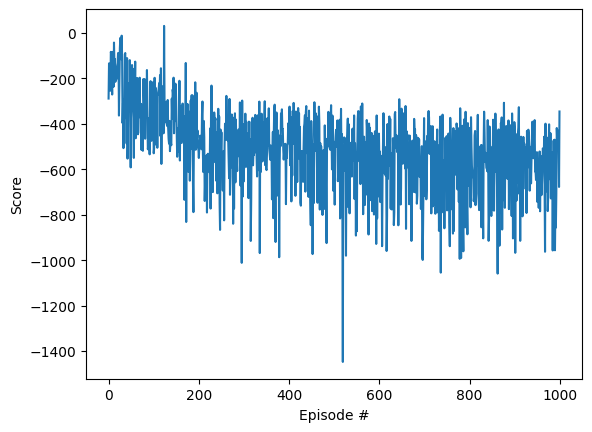

In [6]:
#TODO
# Paramètres de l'épisode
num_episodes = 1000
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995

# Créer l'environnement LunarLander
env = gym.make("LunarLander-v2")

# Initialiser l'agent
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
agent = AgentGlouton(input_dim, output_dim)

# Liste pour stocker les sommes des récompenses
sum_rewards = []

# Initialiser epsilon
epsilon = epsilon_start

# Boucle sur les épisodes
for episode in range(num_episodes):
    state, info = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.act_egreedy(state, epsilon)
        
        next_state, reward, done, truncated, info = env.step(action)

        total_reward += reward
        state = next_state
    
    epsilon = max(epsilon_end, epsilon_decay * epsilon)

    sum_rewards.append(total_reward)
    
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes}: Total Reward = {total_reward}, Epsilon = {epsilon:.4f}")

utils.plot_sumrwdperepi(sum_rewards)

env.close()


# 5. Deep QLearning avec Replay Buffer

L'algorithme (sans réseau cible) est donné ci-dessous:

<img src='img/DQN2.png'  width=700px>


- La phase d'**échantillonage** est une phase d'interaction avec l'environnement (sans apprentissage), pendant laquelle l'agent stocke en mémoire toutes les transitions rencontrées. Une transition est un tuple `(état,action,état_suivant,récompense,fin_episode)`. La mémoire a une taille maximale; lorsqu’elle est dépassée, les nouvelles transitions remplacent les plus anciennes. 

- La phase d'**apprentissage** permet de mettre à jour les paramètres de la fonction *Q* à partir de plusieurs (minibatch) transitions (64 par exemple) stockées dans la mémoire. La phase d'apprentissage est réalisée toutes les `x` interactions avec l'environnement (par ex. $x=4$).

- La classe `ReplayBuffer` du fichier `replaybuffer.py` permet de stocker des transitions dans une mémoire et de récupérer des minibatch de transitions.


Vous devez implémenter l'algorithme du **Deep QLearning avec ReplayBuffer** donné ci-dessus.

Remarque: 
- vous n'utiliserez pas de réseau cible (*target network*) pour l'instant.
- Pour l'optimizer, SGD et [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) sont particulièrement adaptés. 
- Dans la phase d'apprentissage, les éléments récupérés dans un minibatch  sont des tenseurs de taille $d \times dim\_element$. Vous devez dans cette phase faire des calculs tensoriel directement (et pas de boucle for sur $d$ !)
- Voici aussi des liens vers différentes fonctions de PyTorch qui pourraient vous être utiles: [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html), [gather](https://pytorch.org/docs/stable/generated/torch.gather.html)


> <span style="color:green">Compléter la classe `AgentDQN`</span> 
>
> <span style="color:green">Implémenter l'algorithme dans la fonction dqnalgo ci-dessous </span> 
>
> <span style="color:green">Utiliser cet agent sur plusieurs épisodes dans l'environnement `LunarLander`. Vous proposerez un tracé de la somme des récompenses obtenues par épisode (vous pouvez utiliser `utils.py`).</span> 


 
 

In [10]:
#Reload all modules every time before executing the Python code typed
%autoreload 2
from replaybuffer import ReplayBuffer
from agentdqn import AgentDQN

In [11]:
#ajout d'une variable max_steps à 1000 pour empêcher l'agent de tourner en boucle car il arrive des épisodes où l'agent se bloque et tourne à l'infini
def dqnalgo(agent, env, nb_episodes, eps_start, eps_end, eps_decay, max_steps=1000):
    sum_rewards = []
    epsilon = eps_start
    step_count = 0 
    
    for episode in range(nb_episodes):
        state, info = env.reset()
        total_reward = 0
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            action = agent.act_egreedy(state, epsilon)

            next_state, reward, done, _, _ = env.step(action)
            
            agent.sampling_step(state, action, reward, next_state, done)
            
            #épisode suivant
            state = next_state
            total_reward += reward
            step_count += 1
            steps += 1
            
            # Entraîner le réseau toutes les 4 interactions avec l'environnement
            if step_count % 4 == 0:
                agent.train_step()
    
        epsilon = max(eps_end, eps_decay * epsilon)
        
        sum_rewards.append(total_reward)
        
        print(f"Episode {episode + 1}/{nb_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}, Steps: {steps}")
    
    return sum_rewards


Episode 1/500, Total Reward: -286.0927049863916, Epsilon: 0.9950, Steps: 126
Episode 2/500, Total Reward: -302.25935945489323, Epsilon: 0.9900, Steps: 80
Episode 3/500, Total Reward: -113.81178669266838, Epsilon: 0.9851, Steps: 69
Episode 4/500, Total Reward: -214.9276849467084, Epsilon: 0.9801, Steps: 77
Episode 5/500, Total Reward: -445.1559831244062, Epsilon: 0.9752, Steps: 113
Episode 6/500, Total Reward: -199.42676273310667, Epsilon: 0.9704, Steps: 92
Episode 7/500, Total Reward: -131.73755055189318, Epsilon: 0.9655, Steps: 60
Episode 8/500, Total Reward: -116.36142118531689, Epsilon: 0.9607, Steps: 124
Episode 9/500, Total Reward: -171.78781910316178, Epsilon: 0.9559, Steps: 77
Episode 10/500, Total Reward: -211.8356845741418, Epsilon: 0.9511, Steps: 86
Episode 11/500, Total Reward: -50.57183513623928, Epsilon: 0.9464, Steps: 75
Episode 12/500, Total Reward: -362.78099761518297, Epsilon: 0.9416, Steps: 108
Episode 13/500, Total Reward: -158.97921378152486, Epsilon: 0.9369, Steps:

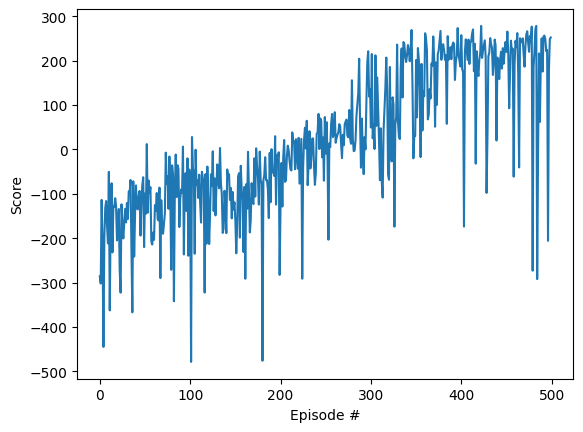

In [12]:
# Initialisation des paramètres et de l'environnement
env = gym.make("LunarLander-v2")
state_size = env.observation_space.shape[0]  # 8
action_size = env.action_space.n             # 4 

# Hyperparamètres pour l'agent et l'entraînement
gamma = 0.99 
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995
nb_episodes = 500

agent = AgentDQN(state_size, action_size, gamma)

sumrwd_over_epi = dqnalgo(agent, env, nb_episodes, eps_start, eps_end, eps_decay)

utils.plot_sumrwdperepi(sumrwd_over_epi)


> <span style="color:green">Faites maintenant une moyenne sur différents seed (un apprentissage par seed) et tracer le résultat moyenné sur ces seed.  (vous pouvez utiliser `utils.py` et init_seed()).</span> </span> 

Episode 1/500, Total Reward: -251.60056020924142, Epsilon: 0.9950, Steps: 112
Episode 2/500, Total Reward: -61.630556568412224, Epsilon: 0.9900, Steps: 69
Episode 3/500, Total Reward: -235.06056390181823, Epsilon: 0.9851, Steps: 90
Episode 4/500, Total Reward: -129.9816849457526, Epsilon: 0.9801, Steps: 89
Episode 5/500, Total Reward: -153.99947944603792, Epsilon: 0.9752, Steps: 137
Episode 6/500, Total Reward: -194.09961883125936, Epsilon: 0.9704, Steps: 114
Episode 7/500, Total Reward: -274.4410306845783, Epsilon: 0.9655, Steps: 84
Episode 8/500, Total Reward: -148.61048579861816, Epsilon: 0.9607, Steps: 75
Episode 9/500, Total Reward: -112.01645286646502, Epsilon: 0.9559, Steps: 115
Episode 10/500, Total Reward: -292.3293631192108, Epsilon: 0.9511, Steps: 105
Episode 11/500, Total Reward: -117.65699958674917, Epsilon: 0.9464, Steps: 82
Episode 12/500, Total Reward: -153.83871190048475, Epsilon: 0.9416, Steps: 111
Episode 13/500, Total Reward: -280.6911793236135, Epsilon: 0.9369, Ste

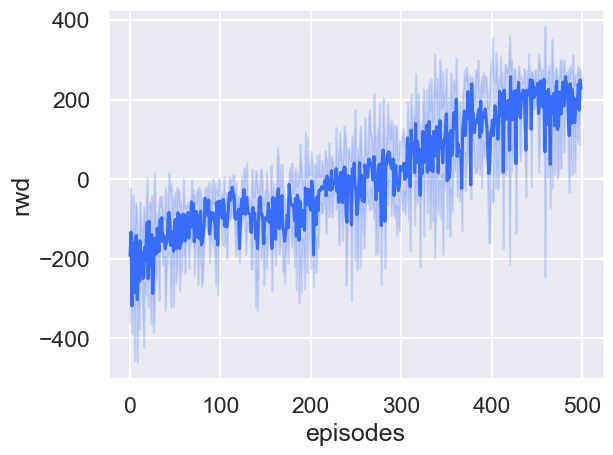

In [13]:
def dqn_multi_seed(agent_class, env, nb_episodes, eps_start, eps_end, eps_decay, seeds):
    rewards_over_seeds = []
    
    for seed in seeds:
        init_seed(seed)
        agent = agent_class(env.observation_space.shape[0], env.action_space.n)
        sum_rewards = dqnalgo(agent, env, nb_episodes, eps_start, eps_end, eps_decay)
        # Convertir sum_rewards en une liste de listes où chaque élément est une liste à un seul élément
        formatted_rewards = [[reward] for reward in sum_rewards]
        rewards_over_seeds.append(formatted_rewards)
    
    return rewards_over_seeds


nb_episodes = 500
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995
seeds = [1, 42, 123, 2024]

env = gym.make("LunarLander-v2")

rewards_over_seeds = dqn_multi_seed(AgentDQN, env, nb_episodes, eps_start, eps_end, eps_decay, seeds)

utils.plot_sumrwdperepi_overseed(rewards_over_seeds)

# 6. Deep QLearning avec réseau cible

Il se peut que votre agent précédent apprenne des comportements intéressants mais qu’ils soient très instables. On va maintenant ajouter un réseau cible pour l'améliorer.

> <span style="color:green"> Quelle est la cause des instabilités de l'algorithme précédent ? Pourquoi le réseau cible améliore ces instabilités ?</span> 

> <span style="color:blue">Votre réponse: </span>

L'instabilité de l'algorithme précédent vient du fait que les cibles changent constament ce qui peut empêcher la convergence.
Le réseau améliore cette stabilité avec des cibles fixes pendant plusieurs itérations, ce qui stabilise les mises à jour des poids facilitant l'apprentissage.

L'algorithme DQN (avec réseau cible) est donné ci-dessous:

<img src='img/DQNcible.png'  width=500px>


Pour la mise à jour du réseau cible, vous pouvez:
- toutes les N étapes d'apprentissage (10000 par exemple), recopier entièrement le réseau de neurone original dans le duplicat
- mettre à jour petit à petit le duplicat à chaque étape d’apprentissage : $$\theta^- = (1-\tau)\theta^- +\tau \theta$$ où $\theta^-$ sont les poids du duplicat, $\theta$ les poids du réseau original, et $\tau$ le pas de mise à jour. Souvent $\tau = 0.001$.


Pour copier des poids d'un réseau de neurone vers un autre, la méthode `copy_` peut être appelée sur les paramètres:

`for param_duplicat, param_source in zip(model_duplicat.parameters(), model_source.parameters()):`
           
`param_duplicat.data.copy_(param_source.data)`

> <span style="color:green"> Compléter la classe `AgentDQNTarget` pour implémenter un agent apprenant avec DQN (deep QLearning et *target network*).</span> 






> <span style="color:green">Utiliser cet agent dans l'algorithme dqnalgo précédent. Vous proposerez un tracé de la somme des récompenses obtenues par épisode sur plusieurs seed.</span> 

In [7]:
from agentdqntarget import AgentDQNTarget

Episode 1/1000, Total Reward: -153.43835496967338, Epsilon: 0.9950, Steps: 106
Episode 2/1000, Total Reward: -304.03981580254856, Epsilon: 0.9900, Steps: 122
Episode 3/1000, Total Reward: -352.17475231317565, Epsilon: 0.9851, Steps: 69
Episode 4/1000, Total Reward: -96.06288282976661, Epsilon: 0.9801, Steps: 81
Episode 5/1000, Total Reward: -439.9381727259976, Epsilon: 0.9752, Steps: 94
Episode 6/1000, Total Reward: -273.87059117019595, Epsilon: 0.9704, Steps: 107
Episode 7/1000, Total Reward: -59.40744968487368, Epsilon: 0.9655, Steps: 69
Episode 8/1000, Total Reward: -159.22830247138853, Epsilon: 0.9607, Steps: 105
Episode 9/1000, Total Reward: -274.799042748709, Epsilon: 0.9559, Steps: 91
Episode 10/1000, Total Reward: -110.81146813726868, Epsilon: 0.9511, Steps: 90
Episode 11/1000, Total Reward: -342.36160454395554, Epsilon: 0.9464, Steps: 89
Episode 12/1000, Total Reward: -122.25292762861142, Epsilon: 0.9416, Steps: 80
Episode 13/1000, Total Reward: -168.0323784634749, Epsilon: 0.

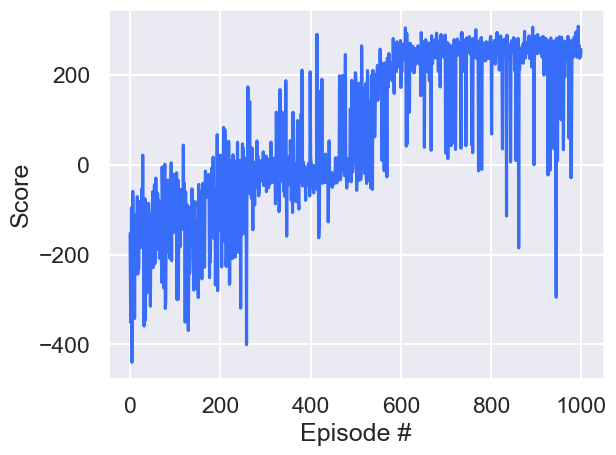

In [24]:
# TODO
#ajout d'une variable max_steps à 1000 pour empêcher l'agent de tourner en boucle car il arrive des épisodes où l'agent se bloque et tourne à l'infini
def dqnalgo_target(agent, env, nb_episodes, eps_start, eps_end, eps_decay, max_steps=1000):
    sum_rewards = []
    epsilon = eps_start
    step_count = 0
    
    for episode in range(nb_episodes):
        state, info = env.reset()
        total_reward = 0
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            action = agent.act_egreedy(state, epsilon)
            
            next_state, reward, done, _, _ = env.step(action)
            
            agent.sampling_step(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            step_count += 1
            steps += 1
            
            if step_count % 4 == 0:
                agent.train_step()

        epsilon = max(eps_end, eps_decay * epsilon)

        sum_rewards.append(total_reward)
        
        print(f"Episode {episode + 1}/{nb_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}, Steps: {steps}")
    
    return sum_rewards


# Initialisation des paramètres et de l'environnement
env = gym.make("LunarLander-v2")
state_size = env.observation_space.shape[0]  # 8
action_size = env.action_space.n             # 4 

# Hyperparamètres pour l'agent et l'entraînement
gamma = 0.99 
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995
nb_episodes = 1000 # pas besoin de plus de 600

agent = AgentDQNTarget(state_size, action_size, gamma)

sumrwd_over_epi = dqnalgo(agent, env, nb_episodes, eps_start, eps_end, eps_decay)

utils.plot_sumrwdperepi(sumrwd_over_epi)

Entraînement avec batch_size=32, learning_rate=0.001
Episode 1/500, Total Reward: -102.89740429189783, Epsilon: 0.9950, Steps: 65
Episode 2/500, Total Reward: -82.16990687443194, Epsilon: 0.9900, Steps: 127
Episode 3/500, Total Reward: -209.92203161010883, Epsilon: 0.9851, Steps: 67
Episode 4/500, Total Reward: -284.33282903721476, Epsilon: 0.9801, Steps: 104
Episode 5/500, Total Reward: -356.8437014644112, Epsilon: 0.9752, Steps: 93
Episode 6/500, Total Reward: -374.2433738732158, Epsilon: 0.9704, Steps: 100
Episode 7/500, Total Reward: -131.0293133377641, Epsilon: 0.9655, Steps: 60
Episode 8/500, Total Reward: -61.90516984125412, Epsilon: 0.9607, Steps: 83
Episode 9/500, Total Reward: -261.34256939678556, Epsilon: 0.9559, Steps: 106
Episode 10/500, Total Reward: -106.64336618095012, Epsilon: 0.9511, Steps: 127
Episode 11/500, Total Reward: -131.94844054211504, Epsilon: 0.9464, Steps: 108
Episode 12/500, Total Reward: -83.34963042767697, Epsilon: 0.9416, Steps: 87
Episode 13/500, Tota

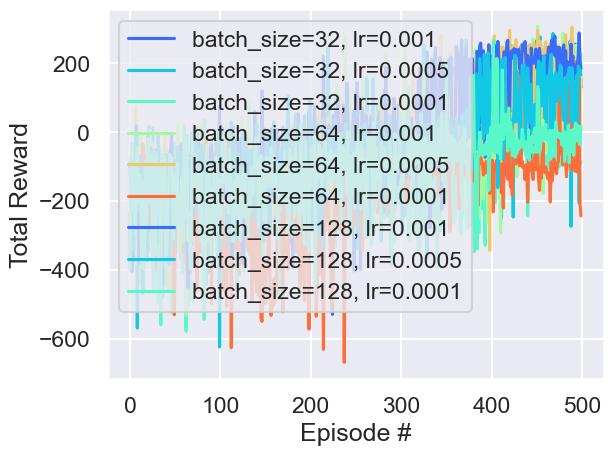

In [15]:
from itertools import product

#ajout d'une variable max_steps à 1000 pour empêcher l'agent de tourner en boucle car il arrive des épisodes où l'agent se bloque et tourne à l'infini
def train_dqn_with_hyperparams(env, state_size, action_size, nb_episodes, gamma, eps_start, eps_end, eps_decay, batch_sizes, learning_rates, max_steps=1000):
    results = {}

    for batch_size, lr in product(batch_sizes, learning_rates):
        print(f"Entraînement avec batch_size={batch_size}, learning_rate={lr}")
        
        agent = AgentDQNTarget(state_size, action_size, gamma, lr=lr, batch_size=batch_size)
        
        sum_rewards = dqnalgo_target(agent, env, nb_episodes, eps_start, eps_end, eps_decay, max_steps)
        
        results[(batch_size, lr)] = sum_rewards
        
        print(f"Fin de l'entraînement pour batch_size={batch_size}, learning_rate={lr}\n")
    
    return results

# Hyperparamètres à tester
batch_sizes = [32, 64, 128]
learning_rates = [1e-3, 5e-4, 1e-4]

results = train_dqn_with_hyperparams(
    env=env,
    state_size=state_size,
    action_size=action_size,
    nb_episodes=nb_episodes,
    gamma=gamma,
    eps_start=eps_start,
    eps_end=eps_end,
    eps_decay=eps_decay,
    batch_sizes=batch_sizes,
    learning_rates=learning_rates
)

for (batch_size, lr), rewards in results.items():
    plt.plot(np.arange(len(rewards)), rewards, label=f'batch_size={batch_size}, lr={lr}')
plt.ylabel('Total Reward')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()


> <span style="color:green"> Quel est l'impact de la taille du mini-batch sur la vitesse de convergence, la stabilité et la capacité de généralisation du DQN ?  Justifiez vos réponses. </span>

> <span style="color:blue">Votre réponse: </span>

Vitesse de convergence : Les petits mini-batchs mettent à jour les poids plus fréquemment, les premières étapes de l'apprentissage sont plus rapides, tandis que les grands mini-batchs accelère la convergence à long terme.

Stabilité de l'apprentissage : Les petits mini-batchs génèrent des gradients avec une variance élevée, alors que les grands mini-batchs, en échantillonnant un plus grand nombre de transitions, lissent les gradients et réduisent le bruit, améliorant la stabilité globale.

Capacité de généralisation : Les petits mini-batchs exposent le réseau à une plus grande variété de transitions à chaque mise à jour, encourageant une meilleure exploration de l'espace d'état, tandis que les grands mini-batchs risquent d'échantillonner moins de diversité, conduisant à une généralisation moins efficace.

# 6. Sauvegarde d'un agent

> <span style="color:green"> Sauvegarder un agent qui a correctement appris dans un fichier 'monAgentDQN.pth'. Vous préciserez ci-dessous les hyperparamètres utilisés pour cet agent. </span> 



> <span style="color:blue">Hyperparamètres de l'agent: </span>

epochs : 500
batch_size : 64
learning rate : 0.0005

In [17]:
#Exemple de code pour sauvegarde d'un réseau
#savedfile = 'checkpoint.pth'
#torch.save(agent.qnetwork.state_dict(), savedfile)

#Exemple de code pour chargement d'un reseau sauvegarde
#state_dict = torch.load(savedfile)
#agent.qnetwork.load_state_dict(state_dict)

gamma = 0.99
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995
nb_episodes = 500
batch_size = 64
learning_rate = 0.0005
tau = 0.001
update_every = 10000

env = gym.make("LunarLander-v2")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n             
agent = AgentDQNTarget(state_size, action_size, gamma, lr=learning_rate, batch_size=batch_size, tau=tau, update_every=update_every)

# Entraînement de l'agent
sum_rewards = dqnalgo_target(agent, env, nb_episodes, eps_start, eps_end, eps_decay)

saved_file = 'monAgentDQN.pth'
torch.save(agent.qnetwork.state_dict(), saved_file)
print(f"Agent sauvegardé dans le fichier {saved_file}")

loaded_state_dict = torch.load(saved_file)
agent.qnetwork.load_state_dict(loaded_state_dict)
print(f"Agent chargé à partir du fichier {saved_file}")


Episode 1/500, Total Reward: -117.63517301812604, Epsilon: 0.9950, Steps: 60
Episode 2/500, Total Reward: -138.1821253350834, Epsilon: 0.9900, Steps: 64
Episode 3/500, Total Reward: -235.47434872823524, Epsilon: 0.9851, Steps: 89
Episode 4/500, Total Reward: 1.1526553247982463, Epsilon: 0.9801, Steps: 114
Episode 5/500, Total Reward: -105.71478260862604, Epsilon: 0.9752, Steps: 89
Episode 6/500, Total Reward: -101.89224775825768, Epsilon: 0.9704, Steps: 76
Episode 7/500, Total Reward: -249.2625931838287, Epsilon: 0.9655, Steps: 107
Episode 8/500, Total Reward: -103.47817579995368, Epsilon: 0.9607, Steps: 122
Episode 9/500, Total Reward: -140.7574910136671, Epsilon: 0.9559, Steps: 74
Episode 10/500, Total Reward: -414.1178172902131, Epsilon: 0.9511, Steps: 85
Episode 11/500, Total Reward: -103.38056738247758, Epsilon: 0.9464, Steps: 91
Episode 12/500, Total Reward: -151.99678979200974, Epsilon: 0.9416, Steps: 86
Episode 13/500, Total Reward: -133.4277989039556, Epsilon: 0.9369, Steps: 9

> <span style="color:green"> Proposer un code ci-dessous pour visualiser un épisode de cet agent en mode glouton. </span> 


In [23]:
agent = AgentDQNTarget(state_size, action_size, gamma, lr=learning_rate, batch_size=batch_size, tau=tau, update_every=update_every)

saved_file = 'monAgentDQN.pth'
agent.qnetwork.load_state_dict(torch.load(saved_file))
print(f"Agent chargé à partir du fichier {saved_file}")

env = gym.make("LunarLander-v2", render_mode="human")

state, info = env.reset()
done = False
total_reward = 0

while not done:
    action = agent.act_egreedy(state, eps=0.0)

    next_state, reward, done, _, _ = env.step(action)

    state = next_state
    total_reward += reward

print(f"Total Reward: {total_reward}")

env.close()


Agent chargé à partir du fichier monAgentDQN.pth
Total Reward: 58.690522692853826


> <span style="color:green"> Si vous avez testé différents hyperparamètres, vous pouvez le préciser ci-dessous. </span> 

> <span style="color:blue">Hyperparamètres testés: </span>